# Evaluación de Resultados del Modelo

Este notebook permite:
1. Cargar los resultados guardados en archivos H5
2. Visualizar las predicciones usando el módulo `visualizer`
3. Calcular y comparar métricas para:
   - La imagen completa
   - La región central (32x32 píxeles)

In [132]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Agregar la raíz del proyecto al Python path
PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Importar funciones del módulo visualizer
from src.visualization.visualizer import (
    visualize_prediction,
    visualize_sample,
    setup_custom_cmap,
    format_timestamp
)

# Configurar estilo de las gráficas
plt.rcParams.update({
    'figure.figsize': [10.0, 8.0],
    'figure.dpi': 100,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.facecolor': 'white',
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})
%matplotlib inline

In [133]:
# Abrir el archivo H5
h5_path = '/Users/diego/Documents/tesis_standalone/tesis_unet_2/logs/unet3/test_results.h5'

def print_h5_structure(name, obj):
    """Función helper para imprimir la estructura completa del archivo H5"""
    indent = "  " * name.count("/")
    if isinstance(obj, h5py.Dataset):
        print(f"{indent}Dataset: {name.split('/')[-1]}")
        print(f"{indent}  Shape: {obj.shape}")
        print(f"{indent}  Type: {obj.dtype}")
        if len(obj.attrs) > 0:
            print(f"{indent}  Attributes:")
            for key, val in obj.attrs.items():
                print(f"{indent}    {key}: {val}")
    elif isinstance(obj, h5py.Group):
        print(f"{indent}Group: {name.split('/')[-1]}")
        if len(obj.attrs) > 0:
            print(f"{indent}  Attributes:")
            for key, val in obj.attrs.items():
                print(f"{indent}    {key}: {val}")

# Abrir y explorar el archivo
with h5py.File(h5_path, 'r') as f:
    print("Estructura del archivo H5:")
    print("========================")
    f.visititems(print_h5_structure)

Estructura del archivo H5:
Dataset: inputs
  Shape: (29, 12, 128, 128)
  Type: float32
Dataset: predictions
  Shape: (29, 6, 128, 128)
  Type: float32
Dataset: targets
  Shape: (29, 6, 128, 128)
  Type: float32


In [129]:
def visualize_prediction(input_data, target, prediction, frame_idx=0):
    """Visualiza predicción para un frame específico"""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Mostrar último frame de entrada
    im = axs[0].imshow(input_data[frame_idx, -1], cmap='terrain')
    axs[0].set_title(f'Último input')
    plt.colorbar(im, ax=axs[0])
    
    # Mostrar objetivo
    im = axs[1].imshow(target[frame_idx, 0], cmap='terrain')
    axs[1].set_title(f'Target')
    plt.colorbar(im, ax=axs[1])
    
    # Mostrar predicción
    im = axs[2].imshow(prediction[frame_idx, 0], cmap='terrain')
    axs[2].set_title(f'Predicción')
    plt.colorbar(im, ax=axs[2])
    
    plt.tight_layout()
    plt.show()

# Cargar y visualizar datos
results = load_results(h5_path)
predictions, targets, inputs, metadata, timestamps = results

# Visualizar un ejemplo
frame_idx = 0  # Cambiar para ver diferentes frames
visualize_prediction(
    inputs, 
    targets, 
    predictions,
    frame_idx
)

KeyError: 'Unable to synchronously open object (message type not found)'

In [130]:
# Nueva implementación de load_results, get_center_crop y calculate_metrics

def load_results(h5_path):
    """Carga los resultados y timestamps desde un archivo H5"""
    with h5py.File(h5_path, 'r') as f:
        # Cargar inputs
        if 'inputs/data' in f:
            inputs = f['inputs/data'][:]
        elif 'inputs' in f:
            inputs = f['inputs'][:]
        else:
            raise KeyError("No se encontró el dataset 'inputs' en el archivo H5")
        # Cargar targets
        if 'targets/data' in f:
            targets = f['targets/data'][:]
        elif 'targets' in f:
            targets = f['targets'][:]
        else:
            raise KeyError("No se encontró el dataset 'targets' en el archivo H5")
        # Cargar predictions
        if 'predictions/data' in f:
            predictions = f['predictions/data'][:]
        elif 'predictions' in f:
            predictions = f['predictions'][:]
        else:
            raise KeyError("No se encontró el dataset 'predictions' en el archivo H5")
        # Cargar timestamps si existen
        timestamps = None
        if 'inputs/timestamps' in f and 'targets/timestamps' in f:
            input_ts = [ts.decode('utf-8') for ts in f['inputs/timestamps'][:]]
            target_ts = [ts.decode('utf-8') for ts in f['targets/timestamps'][:]]
            timestamps = input_ts + target_ts
        elif 'timestamps' in f:
            timestamps = [ts.decode('utf-8') for ts in f['timestamps'][:]]
        # Cargar metadatos
        metadata = {key: f.attrs[key] for key in f.attrs.keys()}
    return predictions, targets, inputs, metadata, timestamps


def get_center_crop(tensor, size=32):
    """Extrae el cuadrado central de un tensor 4D (batch, frames, H, W) o 3D (frames, H, W) o 2D"""
    shape = tensor.shape
    if len(shape) == 4:
        _, _, H, W = shape
        h0, w0 = H//2 - size//2, W//2 - size//2
        return tensor[:, :, h0:h0+size, w0:w0+size]
    elif len(shape) == 3:
        _, H, W = shape
        h0, w0 = H//2 - size//2, W//2 - size//2
        return tensor[:, h0:h0+size, w0:w0+size]
    else:
        H, W = shape
        h0, w0 = H//2 - size//2, W//2 - size//2
        return tensor[h0:h0+size, w0:w0+size]

def calculate_metrics(y_true, y_pred, threshold=0.0):
    """Calcula todas las métricas de evaluación"""
    # MSE
    mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
    
    # Convertir a tensores de PyTorch para usar las funciones existentes
    y_true_tensor = torch.from_numpy(y_true)
    y_pred_tensor = torch.from_numpy(y_pred)
    
    # Binarizar para métricas de clasificación
    y_true_bin = (y_true_tensor > threshold).float()
    y_pred_bin = (y_pred_tensor > threshold).float()
    
    # Calcular TP, FP, FN, TN
    TP = torch.sum((y_pred_bin == 1) & (y_true_bin == 1)).float()
    FP = torch.sum((y_pred_bin == 1) & (y_true_bin == 0)).float()
    FN = torch.sum((y_pred_bin == 0) & (y_true_bin == 1)).float()
    TN = torch.sum((y_pred_bin == 0) & (y_true_bin == 0)).float()
    
    # CSI (Critical Success Index)
    csi = TP / (TP + FN + FP + 1e-8)
    
    # FAR (False Alarm Rate)
    far = FP / (TP + FP + 1e-8)
    
    # HSS (Heidke Skill Score)
    num = 2 * (TP * TN - FP * FN)
    den = (TP + FN) * (FN + TN) + (TP + FP) * (FP + TN)
    hss = num / (den + 1e-8)
    
    return {
        'mse': mse,
        'csi': csi.item(),
        'far': far.item(),
        'hss': hss.item()
    }

## Cargar y Analizar Resultados

Primero cargamos los resultados del archivo H5. Los archivos están organizados por modelo:
- `logs/unet3/test_results_*.h5`
- `logs/unet4/test_results_*.h5`
- `logs/last12/test_results_*.h5`

In [123]:
# Definir path base del proyecto
PROJECT_PATH = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))

# Listar archivos H5 disponibles
print("Archivos H5 disponibles:")
for model in ['unet3', 'unet4', 'last12']:
    model_path = os.path.join(PROJECT_PATH, "logs", model)
    if os.path.exists(model_path):
        h5_files = [f for f in os.listdir(model_path) if f.endswith('.h5')]
        if h5_files:
            print(f"\n{model}:")
            for f in h5_files:
                print(f"  - {f}")

# Cargar resultados (ajusta el path según el modelo que quieras analizar)
h5_path = os.path.join(PROJECT_PATH, "logs/unet4/test_results.h5")
print(f"\nCargando archivo: {h5_path}")

predictions, targets, inputs, metadata, timestamps = load_results(h5_path)

print("\nInformación del modelo:")
for key, value in metadata.items():
    print(f"{key}: {value}")

print("\nDimensiones de los arrays:")
print(f"Predictions: {predictions.shape}")
print(f"Targets: {targets.shape}")
print(f"Inputs: {inputs.shape}")

Archivos H5 disponibles:

unet3:
  - test_results.h5

unet4:
  - test_results.h5

last12:
  - test_results.h5

Cargando archivo: /Users/diego/Documents/tesis_standalone/tesis_unet_2/logs/unet4/test_results.h5


KeyError: 'Unable to synchronously open object (message type not found)'

## Visualización de Predicciones

Visualizamos las predicciones usando las funciones del módulo `visualizer`:
1. Secuencia de entrada (12 frames)
2. Valores reales (ground truth)
3. Predicciones del modelo


Visualizando muestra 1...


ValueError: Invalid dataset identifier (identifier is not of specified type)

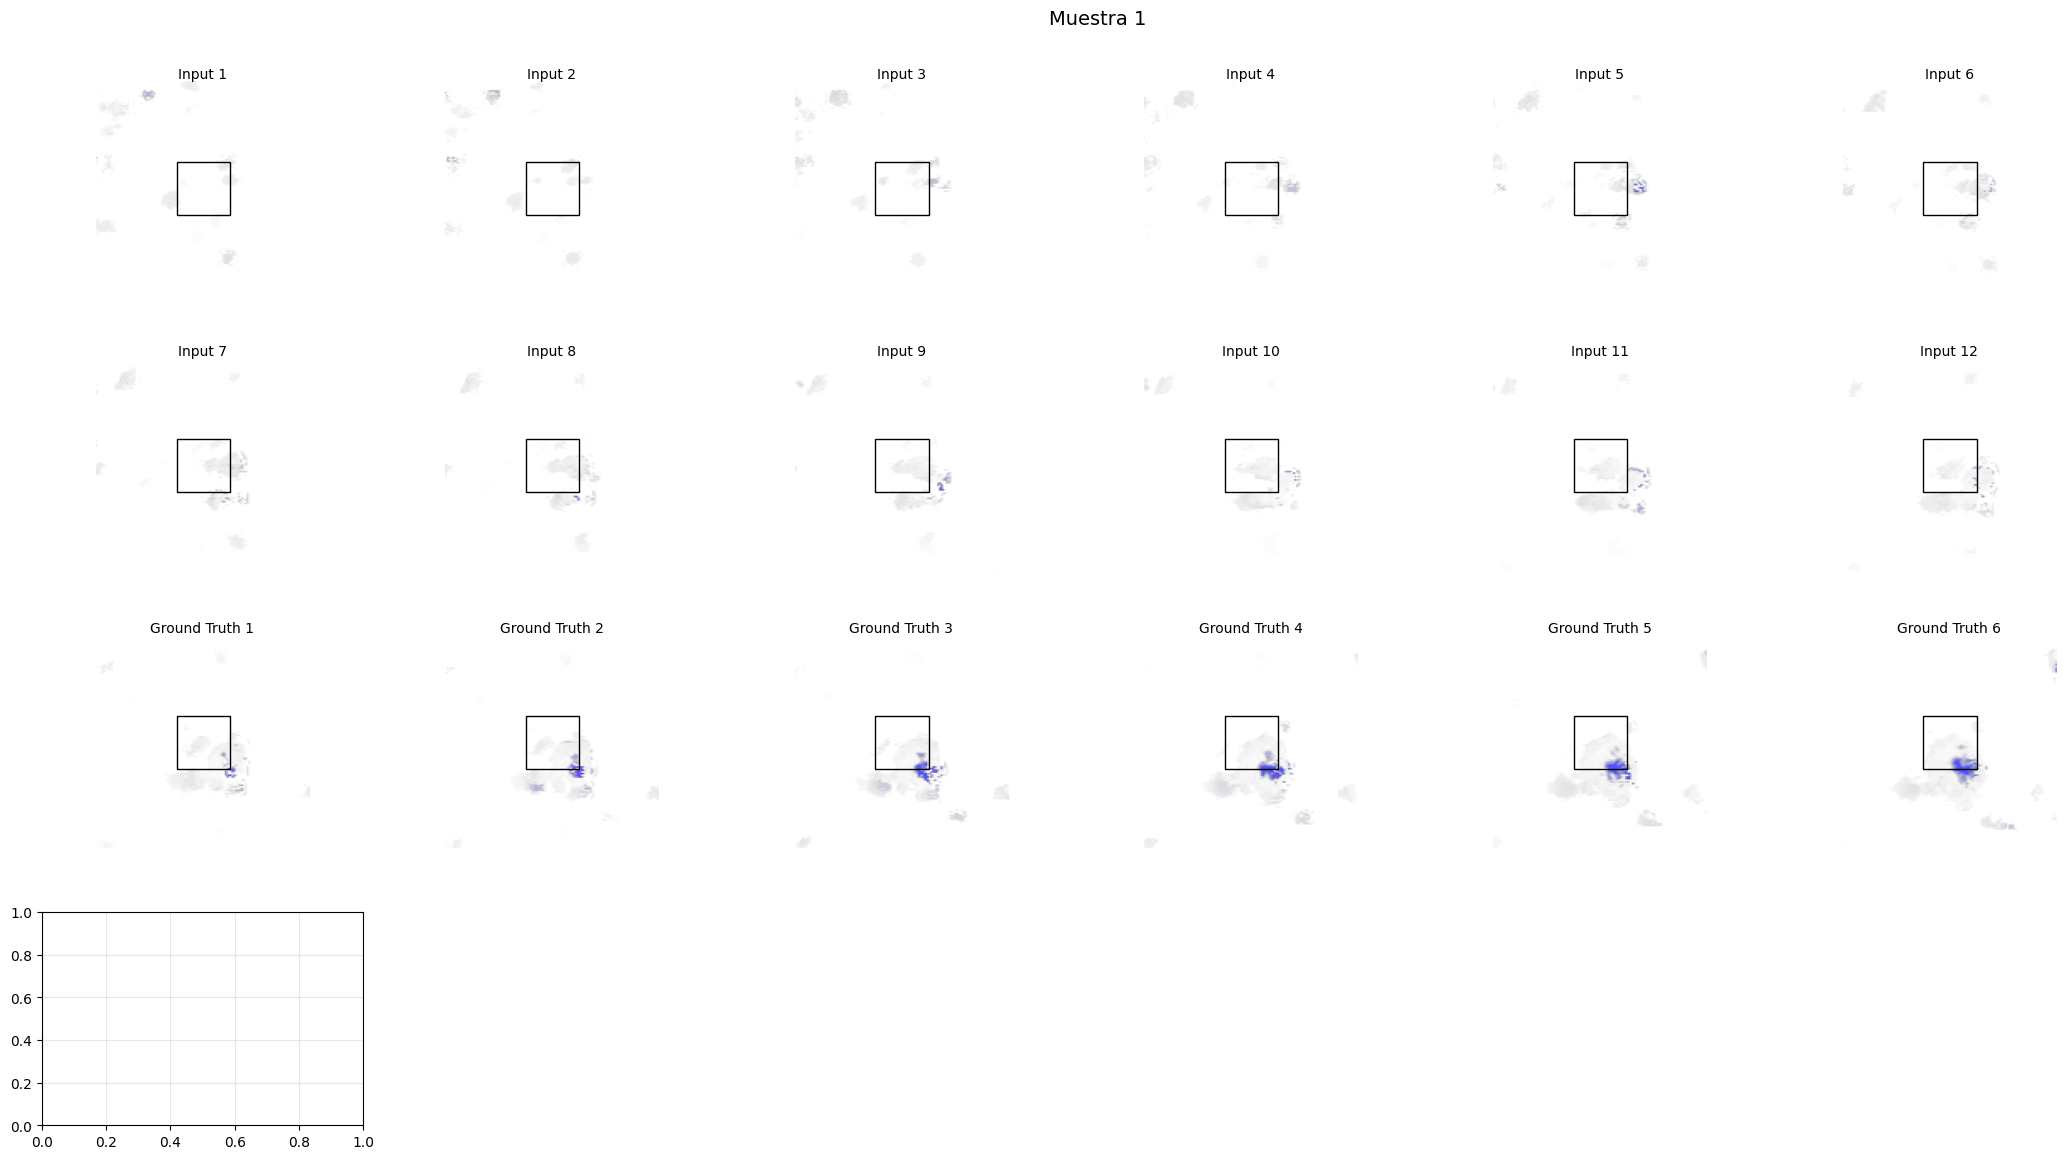

In [131]:
def draw_central_rectangle(ax, image):
    """Función helper para dibujar el rectángulo central"""
    height, width = image.shape
    center_y, center_x = height // 2, width // 2
    rect_size = 32 // 2  # La mitad del tamaño del rectángulo (32x32)
    rect = plt.Rectangle((center_x - rect_size, center_y - rect_size),
                      32, 32, fill=False, color='black', linewidth=1)
    ax.add_patch(rect)

def get_center_crop(image, size=32):
    """Extrae el cuadrado central de una imagen"""
    h, w = image.shape
    start_h = h//2 - size//2
    start_w = w//2 - size//2
    return image[start_h:start_h+size, start_w:start_w+size]

# Configurar visualización
n_rows = 4  # 2 filas para inputs, 1 para ground truth, 1 para predicciones
n_cols = 6  # 6 columnas para cada fila

# Configurar colormap y directorios de salida
custom_cmap = setup_custom_cmap()

base_dir = os.path.join(PROJECT_ROOT, "logs/unet4")
output_dir_full = os.path.join(base_dir, "predicciones_finales")
output_dir_zoom = os.path.join(base_dir, "predicciones")
os.makedirs(output_dir_full, exist_ok=True)
os.makedirs(output_dir_zoom, exist_ok=True)

# Ajustar rangos de los datos para visualización
vmin, vmax = 0, 100  # Rango ajustado a 0-100

# Visualizar las primeras 3 muestras
for idx in range(3):
    print(f"\nVisualizando muestra {idx+1}...")
    
    for viz_type in ['full', 'zoom']:
        # Crear figura con espacio extra a la derecha para la colorbar
        fig = plt.figure(figsize=(22, 12))
        
        # Crear grid para los subplots, dejando espacio para la colorbar
        gs = plt.GridSpec(n_rows, n_cols + 1, width_ratios=[1]*n_cols + [0.05],
                         left=0.02, right=0.98, bottom=0.05, top=0.92,
                         wspace=0.1, hspace=0.3)
        
        # Título de la visualización
        plt.suptitle(f'Muestra {idx+1}', y=0.98, fontsize=14)
        
        # Mostrar frames de entrada (primeros 6)
        for i in range(6):
            ax = fig.add_subplot(gs[0, i])
            frame_data = inputs[idx, i] * 100.0 if inputs[idx, i].max() <= 1.0 else inputs[idx, i]
            if viz_type == 'zoom':
                frame_data = get_center_crop(frame_data)
            im = ax.imshow(frame_data, cmap=custom_cmap, vmin=vmin, vmax=vmax)
            if viz_type == 'full':
                draw_central_rectangle(ax, frame_data)
            ax.set_title(f'Input {i+1}', fontsize=10, pad=2)
            ax.axis('off')
        
        # Mostrar frames de entrada (últimos 6)
        for i in range(6, 12):
            ax = fig.add_subplot(gs[1, i-6])
            frame_data = inputs[idx, i] * 100.0 if inputs[idx, i].max() <= 1.0 else inputs[idx, i]
            if viz_type == 'zoom':
                frame_data = get_center_crop(frame_data)
            im = ax.imshow(frame_data, cmap=custom_cmap, vmin=vmin, vmax=vmax)
            if viz_type == 'full':
                draw_central_rectangle(ax, frame_data)
            ax.set_title(f'Input {i+1}', fontsize=10, pad=2)
            ax.axis('off')
        
        # Mostrar frames de ground truth
        for i in range(6):
            ax = fig.add_subplot(gs[2, i])
            frame_data = targets[idx, i] * 100.0 if targets[idx, i].max() <= 1.0 else targets[idx, i]
            if viz_type == 'zoom':
                frame_data = get_center_crop(frame_data)
            im = ax.imshow(frame_data, cmap=custom_cmap, vmin=vmin, vmax=vmax)
            if viz_type == 'full':
                draw_central_rectangle(ax, frame_data)
            ax.set_title(f'Ground Truth {i+1}', fontsize=10, pad=2)
            ax.axis('off')
        
        # Mostrar frames de predicción
        for i in range(6):
            ax = fig.add_subplot(gs[3, i])
            frame_data = predictions[idx, i] * 100.0 if predictions[idx, i].max() <= 1.0 else predictions[idx, i]
            if viz_type == 'zoom':
                frame_data = get_center_crop(frame_data)
            im = ax.imshow(frame_data, cmap=custom_cmap, vmin=vmin, vmax=vmax)
            if viz_type == 'full':
                draw_central_rectangle(ax, frame_data)
            ax.set_title(f'Prediction {i+1}', fontsize=10, pad=2)
            ax.axis('off')
        
        # Añadir colorbar en la última columna del GridSpec
        cbar_ax = fig.add_subplot(gs[:, -1])
        cbar = plt.colorbar(im, cax=cbar_ax, orientation='vertical')
        cbar.set_label('Intensidad (0-100)', fontsize=10)
        
        # Guardar y mostrar
        output_dir = output_dir_full if viz_type == 'full' else output_dir_zoom
        plt_filename = os.path.join(output_dir, f"prediction_{idx}.jpg")
        plt.savefig(plt_filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Predicción ({viz_type}) guardada en: {plt_filename}")

## Análisis de Métricas: Global vs Centro

Calculamos y comparamos las métricas para:
1. La imagen completa
2. La región central de 32x32 píxeles

In [116]:
# Extraer región central de 32x32
predictions_center = get_center_crop(predictions)
targets_center = get_center_crop(targets)

# Calcular métricas para ambas regiones
metrics_global = calculate_metrics(targets, predictions)
metrics_center = calculate_metrics(targets_center, predictions_center)

# Crear DataFrame comparativo
metrics_df = pd.DataFrame({
    'Global': [metrics_global[k] for k in metrics_global.keys()],
    'Centro 32x32': [metrics_center[k] for k in metrics_center.keys()]
}, index=list(metrics_global.keys()))

# Calcular diferencias porcentuales
metrics_df['Diferencia %'] = ((metrics_df['Centro 32x32'] - metrics_df['Global']) / metrics_df['Global'] * 100).round(2)

# Mostrar tabla de métricas
print("\nComparación de Métricas:")
print(metrics_df.to_string(float_format=lambda x: '{:.6f}'.format(x) if isinstance(x, float) else str(x)))

# Crear visualización comparativa
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(metrics_global))

plt.bar(index, metrics_df['Global'], bar_width, label='Global', color='#2ecc71', alpha=0.8)
plt.bar(index + bar_width, metrics_df['Centro 32x32'], bar_width, label='Centro 32x32', color='#3498db', alpha=0.8)

plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Comparación de Métricas: Global vs Centro')
plt.xticks(index + bar_width/2, metrics_df.index)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Guardar gráfica
metrics_plot_path = os.path.join(output_dir, "metricas_comparativas.png")
plt.savefig(metrics_plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\nGráfica guardada en: {metrics_plot_path}")

ValueError: too many values to unpack (expected 2)

In [ ]:
# Revisar rangos de valores
print("\nRangos de valores:")
print(f"Inputs: min={np.min(inputs):.2f}, max={np.max(inputs):.2f}")
print(f"Targets: min={np.min(targets):.2f}, max={np.max(targets):.2f}")
print(f"Predictions: min={np.min(predictions):.2f}, max={np.max(predictions):.2f}")

# Ver una muestra de datos
idx = 0
print("\nMuestra de valores (primera imagen):")
print("\nInputs[0,0]:")
print(inputs[idx,0])
print("\nTargets[0,0]:")
print(targets[idx,0])
print("\nPredictions[0,0]:")
print(predictions[idx,0])


Rangos de valores:
Inputs: min=0.00, max=1.00
Targets: min=0.00, max=1.00
Predictions: min=-0.10, max=0.67

Muestra de valores (primera imagen):

Inputs[0,0]:
[[0.02105908 0.01533686 0.         ... 0.         0.         0.        ]
 [0.01350528 0.         0.         ... 0.         0.         0.        ]
 [0.00999543 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]

Targets[0,0]:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01597743 0.01597743 0.01597743 ... 0.         0.         0.        ]
 [0.01597743 0.01597743 0.01597743 ... 0.         0.         0.        ]
 [0.0159774